# Data Science Capstone - NY Coffee Shop Sales Analysis

**Import all required Libraries**

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
from itertools import cycle, islice

# Matplotlib and associated plotting modules
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
# print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0
# print(plt.style.available)
mpl.style.use(['ggplot'])

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means, linear regression, polynomial regression, train/test split, and r2 score for evaluation
from sklearn.cluster import KMeans
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

print('Libraries imported.')

Libraries imported.


In [2]:
# Folium library for the maps
#!conda install -c conda-forge folium=0.5.0 --yes
!pip install folium
import folium
from folium import plugins
print('Libraries imported.')

Libraries imported.


In [3]:
# geopy library for geographic coordinates
#!conda install -c conda-forge geopy --yes
!pip install geopy
from geopy.geocoders import Nominatim
print('Libraries imported.')

Libraries imported.


# 1. Obtain Data

In [4]:
# Load Stores information
df_data_1 = pd.read_csv('sales_outlet.csv')
df_stores = df_data_1
df_stores

,sales_outlet_id,sales_outlet_type,store_square_feet,store_address,store_city,store_state_province,store_telephone,store_postal_code,store_longitude,store_latitude,manager,Neighorhood
0,2,warehouse,3400,164-14 Jamaica Ave,Jamaica,NY,972-871-0402,11432,-73.795168,40.705226,NaN,Jamaica
1,3,retail,1300,32-20 Broadway,Long Island City,NY,777-718-3190,11106,-73.924008,40.761196,6.0,Astoria
2,4,retail,1300,604 Union Street,Brooklyn,NY,619-347-5193,11215,-73.983984,40.677645,11.0,Gowanus
3,5,retail,900,100 Church Street,New York,NY,343-212-5151,10007,-74.010130,40.713290,16.0,Lower Manhattan
4,6,retail,1000,122 E Broadway,New York,NY,613-555-4989,10002,-73.992687,40.713852,21.0,Lower East Side
5,7,retail,1200,224 E 57th Street,New York,NY,287-817-2330,10021,-73.960000,40.770000,26.0,Upper East Side
6,8,retail,1500,687 9th Avenue,New York,NY,652-212-7020,10036,-73.990338,40.761887,31.0,Hell's Kitchen
7,9,retail,1700,175 8th Avenue,New York,NY,242-212-0080,10011,-74.000502,40.742760,36.0,Chelsea
8,10,retail,1600,183 W 10th Street,New York,NY,674-646-6434,10014,-74.002722,40.734367,41.0,Greenwich Village


In [5]:
# Load Sales information
df_data_2 = pd.read_csv('201904_sales_reciepts.csv')
df_sales = df_data_2
print('df_sales size: ', df_sales.shape)
df_sales.head()

df_sales size:  (49894, 14)


,transaction_id,transaction_date,transaction_time,sales_outlet_id,staff_id,customer_id,instore_yn,order,line_item_id,product_id,quantity,line_item_amount,unit_price,promo_item_yn
0,7,2019-04-01,12:04:43,3,12,558,N,1,1,52,1,2.50,2.50,N
1,11,2019-04-01,15:54:39,3,17,781,N,1,1,27,2,7.00,3.50,N
2,19,2019-04-01,14:34:59,3,17,788,Y,1,1,46,2,5.00,2.50,N
3,32,2019-04-01,16:06:04,3,12,683,N,1,1,23,2,5.00,2.50,N
4,33,2019-04-01,19:18:37,3,17,99,Y,1,1,34,1,2.45,2.45,N


# 2. Data preprocessing

**Stores information preprocessing**

In [6]:
# Correct the spelling in the solumn heading
df_stores.rename(columns = {'Neighorhood':'Neighborhood'}, inplace = True)
df_stores

,sales_outlet_id,sales_outlet_type,store_square_feet,store_address,store_city,store_state_province,store_telephone,store_postal_code,store_longitude,store_latitude,manager,Neighborhood
0,2,warehouse,3400,164-14 Jamaica Ave,Jamaica,NY,972-871-0402,11432,-73.795168,40.705226,NaN,Jamaica
1,3,retail,1300,32-20 Broadway,Long Island City,NY,777-718-3190,11106,-73.924008,40.761196,6.0,Astoria
2,4,retail,1300,604 Union Street,Brooklyn,NY,619-347-5193,11215,-73.983984,40.677645,11.0,Gowanus
3,5,retail,900,100 Church Street,New York,NY,343-212-5151,10007,-74.010130,40.713290,16.0,Lower Manhattan
4,6,retail,1000,122 E Broadway,New York,NY,613-555-4989,10002,-73.992687,40.713852,21.0,Lower East Side
5,7,retail,1200,224 E 57th Street,New York,NY,287-817-2330,10021,-73.960000,40.770000,26.0,Upper East Side
6,8,retail,1500,687 9th Avenue,New York,NY,652-212-7020,10036,-73.990338,40.761887,31.0,Hell's Kitchen
7,9,retail,1700,175 8th Avenue,New York,NY,242-212-0080,10011,-74.000502,40.742760,36.0,Chelsea
8,10,retail,1600,183 W 10th Street,New York,NY,674-646-6434,10014,-74.002722,40.734367,41.0,Greenwich Village


In [7]:
# Remove the store location where no manager (warehouse)
df_stores.dropna(subset = ['manager'], inplace=True) # Warehouse doesn't have manager
df_stores = df_stores.astype({"manager": int}) # change manger type from float to int
df_stores

,sales_outlet_id,sales_outlet_type,store_square_feet,store_address,store_city,store_state_province,store_telephone,store_postal_code,store_longitude,store_latitude,manager,Neighborhood
1,3,retail,1300,32-20 Broadway,Long Island City,NY,777-718-3190,11106,-73.924008,40.761196,6,Astoria
2,4,retail,1300,604 Union Street,Brooklyn,NY,619-347-5193,11215,-73.983984,40.677645,11,Gowanus
3,5,retail,900,100 Church Street,New York,NY,343-212-5151,10007,-74.010130,40.713290,16,Lower Manhattan
4,6,retail,1000,122 E Broadway,New York,NY,613-555-4989,10002,-73.992687,40.713852,21,Lower East Side
5,7,retail,1200,224 E 57th Street,New York,NY,287-817-2330,10021,-73.960000,40.770000,26,Upper East Side
6,8,retail,1500,687 9th Avenue,New York,NY,652-212-7020,10036,-73.990338,40.761887,31,Hell's Kitchen
7,9,retail,1700,175 8th Avenue,New York,NY,242-212-0080,10011,-74.000502,40.742760,36,Chelsea
8,10,retail,1600,183 W 10th Street,New York,NY,674-646-6434,10014,-74.002722,40.734367,41,Greenwich Village


In [8]:
# To use the Store (neighborhood) name instead of the store id in the analysis
stores_dict = df_stores.set_index('sales_outlet_id').to_dict()['Neighborhood']

**Sales information preprocessing**

In [9]:
# Calculate sales by store by day
df_sales_bystore_byday = df_sales.groupby(['sales_outlet_id', 'transaction_date'], as_index=False)['line_item_amount'].sum()

# Replace store number with neighborhood name
df_sales_bystore_byday = df_sales_bystore_byday.replace(stores_dict)
df_sales_bystore_byday.rename(columns = {'sales_outlet_id':'Store_Neighborhood'}, inplace = True) 

print('df_sales_bystore_byday size: ', df_sales_bystore_byday.shape)
df_sales_bystore_byday.head()

df_sales_bystore_byday size:  (87, 3)


,Store_Neighborhood,transaction_date,line_item_amount
0,Astoria,2019-04-01,2571.40
1,Astoria,2019-04-02,2701.50
2,Astoria,2019-04-03,2759.05
3,Astoria,2019-04-04,2511.75
4,Astoria,2019-04-05,2669.55


In [10]:
# Calculate sales by store
df_sales_bystore = df_sales_bystore_byday.groupby(['Store_Neighborhood'], as_index=False)['line_item_amount'].sum()

print('df_sales_bystore size: ', df_sales_bystore.shape)
df_sales_bystore

df_sales_bystore size:  (3, 2)


,Store_Neighborhood,line_item_amount
0,Astoria,77213.23
1,Hell's Kitchen,79528.25
2,Lower Manhattan,76894.47


In [11]:
df_stores_names = pd.DataFrame(columns=['Store_Neighborhood', 'Store_Latitude', 'Store_Longitude'])
df_stores_names[['Store_Neighborhood', 'Store_Latitude', 'Store_Longitude']] = df_stores[['Neighborhood', 'store_latitude', 'store_longitude']]
df_stores_names

,Store_Neighborhood,Store_Latitude,Store_Longitude
1,Astoria,40.761196,-73.924008
2,Gowanus,40.677645,-73.983984
3,Lower Manhattan,40.713290,-74.010130
4,Lower East Side,40.713852,-73.992687
5,Upper East Side,40.770000,-73.960000
6,Hell's Kitchen,40.761887,-73.990338
7,Chelsea,40.742760,-74.000502
8,Greenwich Village,40.734367,-74.002722


In [12]:
temp = pd.DataFrame(columns=['Store_Neighborhood', 'Store_Latitude', 'Store_Longitude'])
temp[['Store_Neighborhood', 'Store_Latitude', 'Store_Longitude']] = df_stores[['Neighborhood', 'store_latitude', 'store_longitude']]
df_sales_bystore = df_sales_bystore.merge(temp, on='Store_Neighborhood')
df_sales_bystore

,Store_Neighborhood,line_item_amount,Store_Latitude,Store_Longitude
0,Astoria,77213.23,40.761196,-73.924008
1,Hell's Kitchen,79528.25,40.761887,-73.990338
2,Lower Manhattan,76894.47,40.713290,-74.010130


**As the above dataframe contains existing stores, let's create a dataframe for new possible stores**

In [13]:
df_new_stores =df_stores[~df_stores.Neighborhood.isin(df_sales_bystore.Store_Neighborhood)]
df_new_stores

,sales_outlet_id,sales_outlet_type,store_square_feet,store_address,store_city,store_state_province,store_telephone,store_postal_code,store_longitude,store_latitude,manager,Neighborhood
2,4,retail,1300,604 Union Street,Brooklyn,NY,619-347-5193,11215,-73.983984,40.677645,11,Gowanus
4,6,retail,1000,122 E Broadway,New York,NY,613-555-4989,10002,-73.992687,40.713852,21,Lower East Side
5,7,retail,1200,224 E 57th Street,New York,NY,287-817-2330,10021,-73.960000,40.770000,26,Upper East Side
7,9,retail,1700,175 8th Avenue,New York,NY,242-212-0080,10011,-74.000502,40.742760,36,Chelsea
8,10,retail,1600,183 W 10th Street,New York,NY,674-646-6434,10014,-74.002722,40.734367,41,Greenwich Village


In [14]:
df_new_stores_names = df_new_stores[['Neighborhood']]
df_new_stores_names.reset_index()
df_new_stores_names.loc[2]

Neighborhood    Gowanus
Name: 2, dtype: object

# 3. Data Analysis

**Plot Daily sales of stores**

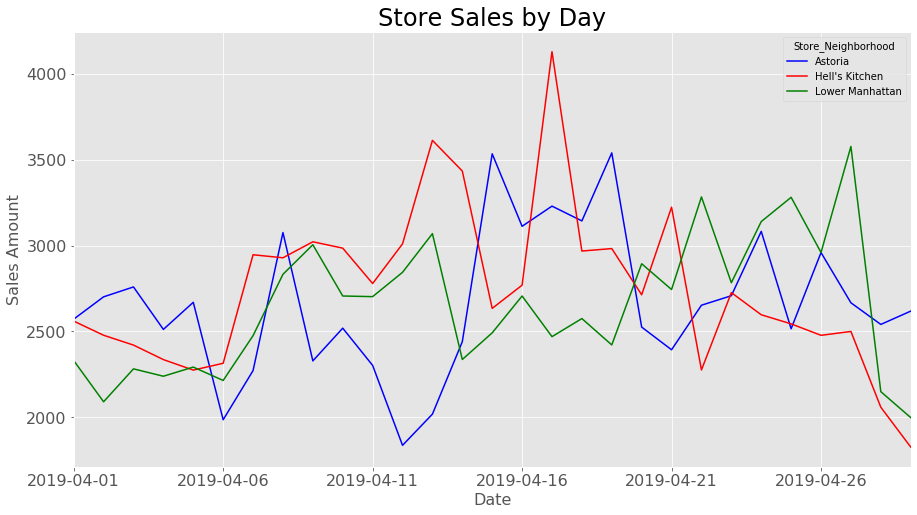

In [15]:
my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, 10))
df_temp = df_sales_bystore_byday.pivot(index='transaction_date', columns='Store_Neighborhood', values='line_item_amount')
df_temp.plot(figsize=(15,8), color=my_colors)
plt.title('Store Sales by Day', fontsize=24)
plt.ylabel('Sales Amount', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.show() # need this line to show the updates made to the figure

**Plot the total sales (per month)**

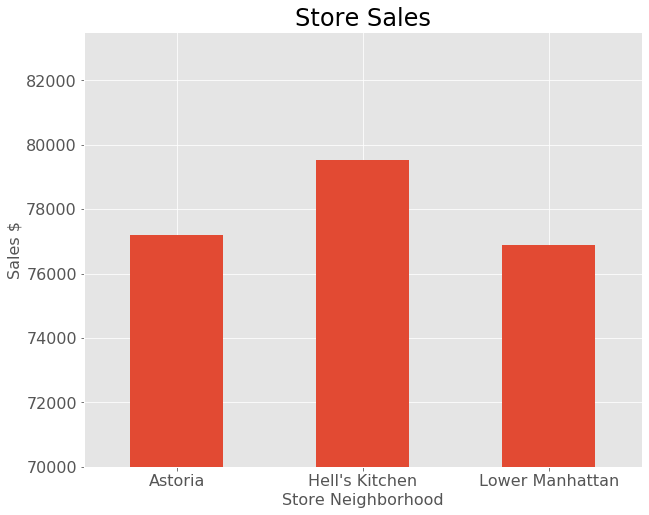

In [16]:
df_sales_bystore.plot(figsize=(10,8), kind='bar', x='Store_Neighborhood', y='line_item_amount', legend=None)
plt.title('Store Sales', fontsize=24)
plt.ylabel('Sales $', fontsize=16)
plt.xlabel('Store Neighborhood', fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16, rotation='horizontal')
plt.ylim(70000,)
plt.show() # need this line to show the updates made to the figure

**Map Store locations**

In [24]:
# Let's get the geographical coordinates of New York City.
address = 'New York City, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
ny_latitude = location.latitude
ny_longitude = location.longitude
print('The geograpical coordinate of New York are {}, {}.'.format(ny_latitude, ny_longitude))

# let's start with the map of New York
map_ny_clst = folium.Map(location = [ny_latitude, ny_longitude], zoom_start = 11)

# instantiate a mark cluster object for the super neighborhood in the dataframe
storemap = plugins.MarkerCluster().add_to(map_ny_clst)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(df_stores['store_latitude'], df_stores['store_longitude'], df_stores['Neighborhood']):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(storemap)

# display map
map_ny_clst

The geograpical coordinate of New York are 40.7127281, -74.0060152.


# 4. Prepare Data for Modeling

**Foursquare Setup**

In [19]:
# Define Foursquare Credentials and Version
CLIENT_ID = 'xxxxxxxxxxx' # your Foursquare ID
CLIENT_SECRET = 'xxxxxxxxxx' # your Foursquare Secret
VERSION = '20200101' # Foursquare API version

**Function to find nearby venues**

In [20]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Store_Neighborhood', 
                  'Store_Latitude', 
                  'Store_Longitude', 
                  'Venue', 
                  'Venue_Latitude', 
                  'Venue_Longitude', 
                  'Venue_Category']
    
    return(nearby_venues)

In [21]:
LIMIT = 100
# run the above function for each store and create a new dataframe 
# called store_venues.
store_venues = getNearbyVenues(names=df_stores['Neighborhood'],
                                   latitudes=df_stores['store_latitude'],
                                   longitudes=df_stores['store_longitude']
                                  )
print(store_venues.shape)
store_venues.head()

Astoria
Gowanus
Lower Manhattan
Lower East Side
Upper East Side
Hell's Kitchen
Chelsea
Greenwich Village
(800, 7)


,Store_Neighborhood,Store_Latitude,Store_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
0,Astoria,40.761196,-73.924008,Astoria Bier & Cheese,40.760581,-73.922542,Cheese Shop
1,Astoria,40.761196,-73.924008,Yoga Agora,40.761200,-73.923862,Yoga Studio
2,Astoria,40.761196,-73.924008,Lockwood,40.760928,-73.924028,Gift Shop
3,Astoria,40.761196,-73.924008,Brooklyn Bagel & Coffee Co.,40.760408,-73.921967,Bagel Shop
4,Astoria,40.761196,-73.924008,King Of Falafel & Shawarma,40.762041,-73.925098,Middle Eastern Restaurant


In [22]:
print('There are {} uniques categories.'.format(len(store_venues['Venue_Category'].unique())))

There are 203 uniques categories.


**New York map with Store locations and nearby Venues**

In [25]:
# NY Map
map_ny = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=11)

# add Store locations to map
for lat, lng, label in zip(df_sales_bystore['Store_Latitude'], df_sales_bystore['Store_Longitude'], df_sales_bystore['Store_Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ny)  

    #for lat, lng, label in zip(df_sales_bystore['Store_Latitude'], df_sales_bystore['Store_Longitude'], df_sales_bystore['Store_Neighborhood']):
for lat, lng, label in zip(df_new_stores['store_latitude'], df_new_stores['store_longitude'], df_new_stores['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ny)  

# add Venues to map
for lat, lng, label in zip(store_venues['Venue_Latitude'], store_venues['Venue_Longitude'], store_venues['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ny)  

# Add legend
lgd_txt = '<span style="color: {col};">{txt}</span>'
fg = folium.FeatureGroup(name= lgd_txt.format( txt= 'Red: current store', col= 'red'))
map_ny.add_child(fg)
fg = folium.FeatureGroup(name= lgd_txt.format( txt= 'Brown: future store', col= 'green'))
map_ny.add_child(fg)
fg = folium.FeatureGroup(name= lgd_txt.format( txt= 'Blue: neighborhood venues', col= 'blue'))
map_ny.add_child(fg)


folium.map.LayerControl('topright', collapsed= False).add_to(map_ny)
map_ny

In [26]:
store_venues['Venue_Category'] = np.where((store_venues['Venue_Category'].str.contains("Restaurant")) |
                                          (store_venues['Venue_Category'].str.contains("Diner")) |
                                          (store_venues['Venue_Category'].str.contains("Steak")) |
                                          (store_venues['Venue_Category'].str.contains("Bistro")) |
                                          (store_venues['Venue_Category'].str.contains("BBQ")),
                                'Restaurant', store_venues['Venue_Category'])
store_venues['Venue_Category'] = np.where((store_venues['Venue_Category'].str.contains("Bakery")) |
                                          (store_venues['Venue_Category'].str.contains("Donut")) |
                                          (store_venues['Venue_Category'].str.contains("Pastry")) |
                                          (store_venues['Venue_Category'].str.contains("Bagel")) |
                                          (store_venues['Venue_Category'].str.contains("Cupcake")) |
                                          (store_venues['Venue_Category'].str.contains("Pie")),
                                'Bakery', store_venues['Venue_Category'])
store_venues['Venue_Category'] = np.where((store_venues['Venue_Category'].str.contains("Coffee")) | 
                                          (store_venues['Venue_Category'].str.contains("Café")) |
                                          (store_venues['Venue_Category'].str.contains("Tea")) |
                                          (store_venues['Venue_Category'].str.contains("Smoothie")),
                                'Coffee', store_venues['Venue_Category'])
store_venues['Venue_Category'] = np.where((store_venues['Venue_Category'].str.contains("Museum")) |
                                          (store_venues['Venue_Category'].str.contains("Antique")) |
                                          (store_venues['Venue_Category'].str.contains("Crafts")) |
                                          (store_venues['Venue_Category'].str.contains("Vintage")) |
                                          (store_venues['Venue_Category'].str.contains("Gallery")),
                                'Museum', store_venues['Venue_Category'])
store_venues['Venue_Category'] = np.where((store_venues['Venue_Category'].str.contains("Candy")) |
                                          (store_venues['Venue_Category'].str.contains("Cheese")) |
                                          (store_venues['Venue_Category'].str.contains("Dessert")) |
                                          (store_venues['Venue_Category'].str.contains("Ice Cream")),
                                'Dessert', store_venues['Venue_Category'])
store_venues['Venue_Category'] = np.where((store_venues['Venue_Category'].str.contains("Food")) |
                                          (store_venues['Venue_Category'].str.contains("Burrito")) |
                                          (store_venues['Venue_Category'].str.contains("Burger")) |
                                          (store_venues['Venue_Category'].str.contains("Taco")) |
                                          (store_venues['Venue_Category'].str.contains("Deli")) |
                                          (store_venues['Venue_Category'].str.contains("Fried")) |
                                          (store_venues['Venue_Category'].str.contains("Noodle")) |
                                          (store_venues['Venue_Category'].str.contains("Pizza")) |
                                          (store_venues['Venue_Category'].str.contains("Salad")) |
                                          (store_venues['Venue_Category'].str.contains("Sandwich")) |
                                          (store_venues['Venue_Category'].str.contains("Poke")) |
                                          (store_venues['Venue_Category'].str.contains("Wings")) |
                                          (store_venues['Venue_Category'].str.contains("Butcher")) |
                                          (store_venues['Venue_Category'].str.contains("Market")),
                                'Food', store_venues['Venue_Category'])
store_venues['Venue_Category'] = np.where((store_venues['Venue_Category'].str.contains("Gym")) | 
                                          (store_venues['Venue_Category'].str.contains("Fitness")) |
                                          (store_venues['Venue_Category'].str.contains("Martial Arts")) |
                                          (store_venues['Venue_Category'].str.contains("Cycle Studio")) |
                                          (store_venues['Venue_Category'].str.contains("Yoga")) |
                                          (store_venues['Venue_Category'].str.contains("Pool Hall")) |
                                          (store_venues['Venue_Category'].str.contains("Indoor Play")) |
                                          (store_venues['Venue_Category'].str.contains("Skate")) |
                                          (store_venues['Venue_Category'].str.contains("Tennis")) |
                                          (store_venues['Venue_Category'].str.contains("Playground")) |
                                          (store_venues['Venue_Category'].str.contains("Pilates")) |
                                          (store_venues['Venue_Category'].str.contains("Physical Therapist")),
                                'Gym', store_venues['Venue_Category'])
store_venues['Venue_Category'] = np.where((store_venues['Venue_Category'].str.contains("Hardware Store")) |
                                          (store_venues['Venue_Category'].str.contains("Bike Shop")) |
                                          (store_venues['Venue_Category'].str.contains("Board Shop")) |
                                          (store_venues['Venue_Category'].str.contains("Outdoor Supply")) |
                                          (store_venues['Venue_Category'].str.contains("Hobby Shop")) |
                                          (store_venues['Venue_Category'].str.contains("Sporting Goods")),
                                'Sporting Store', store_venues['Venue_Category'])
store_venues['Venue_Category'] = np.where((store_venues['Venue_Category'].str.contains("Bus")) |
                                          (store_venues['Venue_Category'].str.contains("Bank")) |
                                          (store_venues['Venue_Category'].str.contains("Hotel")) |
                                          (store_venues['Venue_Category'].str.contains("Non-Profit")) |
                                          (store_venues['Venue_Category'].str.contains("Building")) |
                                          (store_venues['Venue_Category'].str.contains("Plaza")),
                                'Plaza', store_venues['Venue_Category'])
store_venues['Venue_Category'] = np.where((store_venues['Venue_Category'].str.contains("Night")) |
                                          (store_venues['Venue_Category'].str.contains("Comedy Club")) |
                                          (store_venues['Venue_Category'].str.contains("Social Club")) |
                                          (store_venues['Venue_Category'].str.contains("Strip")),
                                'Night Place', store_venues['Venue_Category'])
store_venues['Venue_Category'] = np.where((store_venues['Venue_Category'].str.contains("Stationery")) |
                                          (store_venues['Venue_Category'].str.contains("Office Supply")) |
                                          (store_venues['Venue_Category'].str.contains("Paper")) |
                                          (store_venues['Venue_Category'].str.contains("Souvenir")) |
                                          (store_venues['Venue_Category'].str.contains("Flower")) |
                                          (store_venues['Venue_Category'].str.contains("Book")) |
                                          (store_venues['Venue_Category'].str.contains("Record")) |
                                          (store_venues['Venue_Category'].str.contains("Camera")) |
                                          (store_venues['Venue_Category'].str.contains("Electronics")) |
                                          (store_venues['Venue_Category'].str.contains("Gift")) |
                                          (store_venues['Venue_Category'].str.contains("Shoe")) |
                                          (store_venues['Venue_Category'].str.contains("Miscellaneous")) |
                                          (store_venues['Venue_Category'].str.contains("Accessories")) |
                                          (store_venues['Venue_Category'].str.contains("Phone")) |
                                          (store_venues['Venue_Category'].str.contains("Smoke")),
                                'Miscellaneous Store', store_venues['Venue_Category'])
store_venues['Venue_Category'] = np.where((store_venues['Venue_Category'].str.contains("Women")) |
                                          (store_venues['Venue_Category'].str.contains("Lingerie")) |
                                          (store_venues['Venue_Category'].str.contains("Nail")) |
                                          (store_venues['Venue_Category'].str.contains("Bridal")) |
                                          (store_venues['Venue_Category'].str.contains("Boutique")) |
                                          (store_venues['Venue_Category'].str.contains("Beauty")) |
                                          (store_venues['Venue_Category'].str.contains("Cosmetics")),
                                'Women Store', store_venues['Venue_Category'])
store_venues['Venue_Category'] = np.where((store_venues['Venue_Category'].str.contains("Kid")) |
                                          (store_venues['Venue_Category'].str.contains("Baby")) |
                                          (store_venues['Venue_Category'].str.contains("Child")) |
                                          (store_venues['Venue_Category'].str.contains("Toy")),
                                'Children Store', store_venues['Venue_Category'])
store_venues['Venue_Category'] = np.where((store_venues['Venue_Category'].str.contains("Optical")) |
                                          (store_venues['Venue_Category'].str.contains("Pharmacy")) |
                                          (store_venues['Venue_Category'].str.contains("Supplement")),
                                'Medical', store_venues['Venue_Category'])
store_venues['Venue_Category'] = np.where((store_venues['Venue_Category'].str.contains("Department Store")) |
                                          (store_venues['Venue_Category'].str.contains("Discount Store")) |
                                          (store_venues['Venue_Category'].str.contains("Home Store")) |
                                          (store_venues['Venue_Category'].str.contains("Kitchen Supply")) |
                                          (store_venues['Venue_Category'].str.contains("Shopping Mall")),
                                'Shopping Mall', store_venues['Venue_Category'])
store_venues['Venue_Category'] = np.where((store_venues['Venue_Category'].str.contains("Bar")) | 
                                          (store_venues['Venue_Category'].str.contains("Brewery")) |
                                          (store_venues['Venue_Category'].str.contains("Roof Deck")) |
                                          (store_venues['Venue_Category'].str.contains("Liquor")) |
                                          (store_venues['Venue_Category'].str.contains("Beer")) |
                                          (store_venues['Venue_Category'].str.contains("Wine")) |
                                          (store_venues['Venue_Category'].str.contains("Pub")) |
                                          (store_venues['Venue_Category'].str.contains("pub")) |
                                          (store_venues['Venue_Category'].str.contains("Lounge")) |
                                          (store_venues['Venue_Category'].str.contains("Speakeasy")),
                                'Bar', store_venues['Venue_Category'])
store_venues['Venue_Category'] = np.where((store_venues['Venue_Category'].str.contains("Garden")) | 
                                          (store_venues['Venue_Category'].str.contains("Park")) |
                                          (store_venues['Venue_Category'].str.contains("Outdoors")) |
                                          (store_venues['Venue_Category'].str.contains("Resort")) |
                                          (store_venues['Venue_Category'].str.contains("Scenic")) |
                                          (store_venues['Venue_Category'].str.contains("Site")),
                                'Outdoors', store_venues['Venue_Category'])
store_venues['Venue_Category'] = np.where((store_venues['Venue_Category'].str.contains("Music")) |
                                          (store_venues['Venue_Category'].str.contains("Dance")) |
                                          (store_venues['Venue_Category'].str.contains("Jazz")),
                                'Music Place', store_venues['Venue_Category'])
store_venues['Venue_Category'] = np.where((store_venues['Venue_Category'].str.contains("Spa")) |
                                          (store_venues['Venue_Category'].str.contains("Massage")) |
                                          (store_venues['Venue_Category'].str.contains("Tattoo")),
                                'Spa', store_venues['Venue_Category'])
store_venues['Venue_Category'] = np.where((store_venues['Venue_Category'].str.contains("Pet")),
                                'Pet Store', store_venues['Venue_Category'])
store_venues['Venue_Category'] = np.where((store_venues['Venue_Category'].str.contains("Grocery")) |
                                          (store_venues['Venue_Category'].str.contains("Gourmet")) |
                                          (store_venues['Venue_Category'].str.contains("Herbs")),
                                'Grocery', store_venues['Venue_Category'])
store_venues['Venue_Category'] = np.where((store_venues['Venue_Category'].str.contains("Clothing")) |
                                          (store_venues['Venue_Category'].str.contains("Laundry")) |
                                          (store_venues['Venue_Category'].str.contains("Men")),
                                'Clothing', store_venues['Venue_Category'])
store_venues['Venue_Category'] = np.where((store_venues['Venue_Category'].str.contains("Theater")) |
                                          (store_venues['Venue_Category'].str.contains("Performing Arts")) |
                                          (store_venues['Venue_Category'].str.contains("Concert")) |
                                          (store_venues['Venue_Category'].str.contains("Auditorium")) |
                                          (store_venues['Venue_Category'].str.contains("TV")) |
                                          (store_venues['Venue_Category'].str.contains("Multiplex")),
                                'Theater', store_venues['Venue_Category'])

store_venues.head()

,Store_Neighborhood,Store_Latitude,Store_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
0,Astoria,40.761196,-73.924008,Astoria Bier & Cheese,40.760581,-73.922542,Dessert
1,Astoria,40.761196,-73.924008,Yoga Agora,40.761200,-73.923862,Gym
2,Astoria,40.761196,-73.924008,Lockwood,40.760928,-73.924028,Miscellaneous Store
3,Astoria,40.761196,-73.924008,Brooklyn Bagel & Coffee Co.,40.760408,-73.921967,Bakery
4,Astoria,40.761196,-73.924008,King Of Falafel & Shawarma,40.762041,-73.925098,Restaurant


In [27]:
# After observing data, noticed that Children Store is only near two locations and so dropping this data
store_venues.drop(store_venues[store_venues['Venue_Category']=='Children Store'].index, inplace=True)

# After observing data, noticed that Night Place is only near three locations and so dropping this data
store_venues.drop(store_venues[store_venues['Venue_Category']=='Night Place'].index, inplace=True)

# After observing data, noticed that Pet Store is only near three locations and so dropping this data
store_venues.drop(store_venues[store_venues['Venue_Category']=='Pet Store'].index, inplace=True)

# After observing data, noticed that Sporting Store is not in out training locations and so dropping this data
store_venues.drop(store_venues[store_venues['Venue_Category']=='Sporting Store'].index, inplace=True)

In [28]:
# Let's find out how many unique categories can be curated from all the 
# returned venues
print('There are {} uniques categories.'.format(len(store_venues['Venue_Category'].unique())))
sorted(store_venues['Venue_Category'].unique())

There are 19 uniques categories.


['Bakery',
 'Bar',
 'Clothing',
 'Coffee',
 'Dessert',
 'Food',
 'Grocery',
 'Gym',
 'Medical',
 'Miscellaneous Store',
 'Museum',
 'Music Place',
 'Outdoors',
 'Plaza',
 'Restaurant',
 'Shopping Mall',
 'Spa',
 'Theater',
 'Women Store']

**Venue Categories near each store Neighborhood**

In [29]:
# one hot encoding
store_onehot = pd.get_dummies(store_venues[['Venue_Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
store_onehot['Store_Neighborhood'] = store_venues['Store_Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [store_onehot.columns[-1]] + list(store_onehot.columns[:-1])
store_onehot = store_onehot[fixed_columns]
print('store_onehot shape: ', store_onehot.shape)
store_onehot.head()

store_onehot shape:  (781, 20)


,Store_Neighborhood,Bakery,Bar,Clothing,Coffee,Dessert,Food,Grocery,Gym,Medical,Miscellaneous Store,Museum,Music Place,Outdoors,Plaza,Restaurant,Shopping Mall,Spa,Theater,Women Store
0,Astoria,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Astoria,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,Astoria,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,Astoria,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Astoria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


**Group by store**

In [30]:
store_grouped_bynumber = store_onehot.groupby('Store_Neighborhood').sum().reset_index()
store_grouped_bynumber

,Store_Neighborhood,Bakery,Bar,Clothing,Coffee,Dessert,Food,Grocery,Gym,Medical,Miscellaneous Store,Museum,Music Place,Outdoors,Plaza,Restaurant,Shopping Mall,Spa,Theater,Women Store
0,Astoria,6,19,0,10,2,11,2,6,1,3,0,0,0,0,35,1,2,1,1
1,Chelsea,9,8,2,7,4,7,1,9,2,1,2,0,1,2,25,2,0,6,6
2,Gowanus,3,15,1,8,2,12,3,13,1,5,1,1,0,1,27,0,3,1,1
3,Greenwich Village,4,16,0,7,4,6,2,2,1,7,0,6,2,0,33,0,2,1,5
4,Hell's Kitchen,4,16,1,3,1,10,0,3,0,2,0,2,2,1,37,0,2,14,1
5,Lower East Side,3,16,0,6,5,5,2,2,1,6,1,1,2,1,42,2,2,1,1
6,Lower Manhattan,2,7,4,9,2,10,2,11,0,4,2,1,6,8,19,3,3,1,5
7,Upper East Side,2,10,1,5,2,11,2,9,1,5,2,0,0,2,35,2,0,0,5


**Analyze few features: It shows that (1) coffee sales are more if there are less number of stores in the area 
                                      (2) Coffee sales increse with number of theaters in the area**

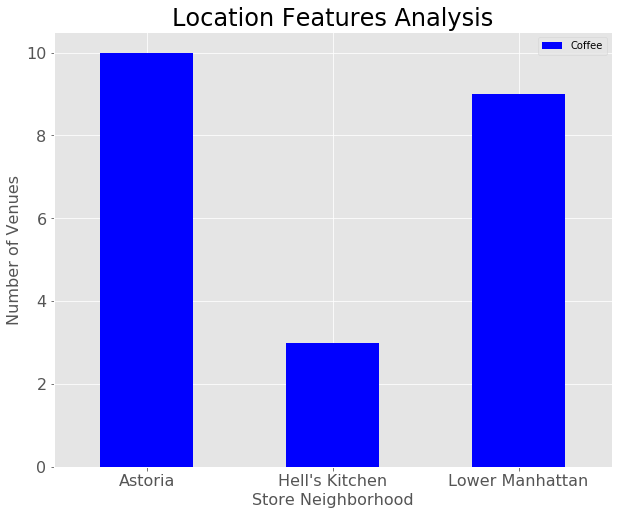

In [31]:
existing_Store_features = store_grouped_bynumber[store_grouped_bynumber.Store_Neighborhood.isin(df_sales_bystore.Store_Neighborhood)]
existing_Store_features.plot(figsize=(10,8), kind='bar', color='blue', x='Store_Neighborhood', y='Coffee')
plt.title('Location Features Analysis', fontsize=24)
plt.ylabel('Number of Venues', fontsize=16)
plt.xlabel('Store Neighborhood', fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16, rotation='horizontal')
plt.show() # need this line to show the updates made to the figure

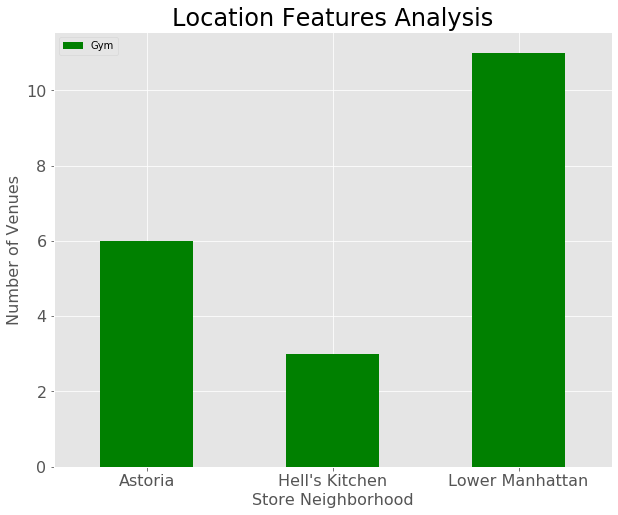

In [32]:
existing_Store_features = store_grouped_bynumber[store_grouped_bynumber.Store_Neighborhood.isin(df_sales_bystore.Store_Neighborhood)]
existing_Store_features.plot(figsize=(10,8), kind='bar', color='green', x='Store_Neighborhood', y='Gym')
plt.title('Location Features Analysis', fontsize=24)
plt.ylabel('Number of Venues', fontsize=16)
plt.xlabel('Store Neighborhood', fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16, rotation='horizontal')
plt.show() # need this line to show the updates made to the figure

**Normalize the data**

In [33]:
# Next, let's group rows by neighborhood and by taking the mean of the 
# frequency of occurrence of each category
store_grouped = store_onehot.groupby('Store_Neighborhood').mean().reset_index()
print('store_grouped shape: ', store_grouped.shape)
store_grouped


store_grouped shape:  (8, 20)


,Store_Neighborhood,Bakery,Bar,Clothing,Coffee,Dessert,Food,Grocery,Gym,Medical,Miscellaneous Store,Museum,Music Place,Outdoors,Plaza,Restaurant,Shopping Mall,Spa,Theater,Women Store
0,Astoria,0.060000,0.190000,0.000000,0.100000,0.020000,0.110000,0.020000,0.060000,0.010000,0.030000,0.000000,0.000000,0.000000,0.000000,0.350000,0.010000,0.020000,0.010000,0.010000
1,Chelsea,0.095745,0.085106,0.021277,0.074468,0.042553,0.074468,0.010638,0.095745,0.021277,0.010638,0.021277,0.000000,0.010638,0.021277,0.265957,0.021277,0.000000,0.063830,0.063830
2,Gowanus,0.030612,0.153061,0.010204,0.081633,0.020408,0.122449,0.030612,0.132653,0.010204,0.051020,0.010204,0.010204,0.000000,0.010204,0.275510,0.000000,0.030612,0.010204,0.010204
3,Greenwich Village,0.040816,0.163265,0.000000,0.071429,0.040816,0.061224,0.020408,0.020408,0.010204,0.071429,0.000000,0.061224,0.020408,0.000000,0.336735,0.000000,0.020408,0.010204,0.051020
4,Hell's Kitchen,0.040404,0.161616,0.010101,0.030303,0.010101,0.101010,0.000000,0.030303,0.000000,0.020202,0.000000,0.020202,0.020202,0.010101,0.373737,0.000000,0.020202,0.141414,0.010101
5,Lower East Side,0.030303,0.161616,0.000000,0.060606,0.050505,0.050505,0.020202,0.020202,0.010101,0.060606,0.010101,0.010101,0.020202,0.010101,0.424242,0.020202,0.020202,0.010101,0.010101
6,Lower Manhattan,0.020202,0.070707,0.040404,0.090909,0.020202,0.101010,0.020202,0.111111,0.000000,0.040404,0.020202,0.010101,0.060606,0.080808,0.191919,0.030303,0.030303,0.010101,0.050505
7,Upper East Side,0.021277,0.106383,0.010638,0.053191,0.021277,0.117021,0.021277,0.095745,0.010638,0.053191,0.021277,0.000000,0.000000,0.021277,0.372340,0.021277,0.000000,0.000000,0.053191


In [34]:
x_train_df = df_sales_bystore[["Store_Neighborhood"]]
x_train_df = x_train_df.merge(store_grouped, on="Store_Neighborhood")
x_train_df.drop(['Store_Neighborhood'], axis=1, inplace=True)
x_train = np.asanyarray(x_train_df)
x_train

array([[0.06      , 0.19      , 0.        , 0.1       , 0.02      ,
        0.11      , 0.02      , 0.06      , 0.01      , 0.03      ,
        0.        , 0.        , 0.        , 0.        , 0.35      ,
        0.01      , 0.02      , 0.01      , 0.01      ],
       [0.04040404, 0.16161616, 0.01010101, 0.03030303, 0.01010101,
        0.1010101 , 0.        , 0.03030303, 0.        , 0.02020202,
        0.        , 0.02020202, 0.02020202, 0.01010101, 0.37373737,
        0.        , 0.02020202, 0.14141414, 0.01010101],
       [0.02020202, 0.07070707, 0.04040404, 0.09090909, 0.02020202,
        0.1010101 , 0.02020202, 0.11111111, 0.        , 0.04040404,
        0.02020202, 0.01010101, 0.06060606, 0.08080808, 0.19191919,
        0.03030303, 0.03030303, 0.01010101, 0.05050505]])

In [35]:
y_train_df = df_sales_bystore[["line_item_amount"]]
y_train = np.asanyarray(y_train_df)
y_train

array([[77213.23],
       [79528.25],
       [76894.47]])

# 5a. Linear Regression Model

In [36]:
regr = linear_model.LinearRegression()
regr.fit (x_train, y_train)
print ('Coefficients: ', regr.coef_) # The coefficients

Coefficients:  [[-1373.46124613 -1460.60805779   537.36450093 -6021.16815914
   -867.98841783  -709.5897161  -1751.92267198 -3037.17744501
   -789.31889768  -946.65793797  -173.28487661  1681.22606999
   1248.01387847   190.79474772  3433.19965669 -1049.24621259
    -70.69660199 11499.11822206  -338.59683506]]


**Test with the same train data as we do not have much data to test**

In [37]:
y_hat = regr.predict(x_train)
y_hat

array([[77213.23],
       [79528.25],
       [76894.47]])

In [38]:
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y_train) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x_train, y_train))

Residual sum of squares: 0.00
Variance score: 1.00


**As the train data is overfitted, let's try 2 records as training and 1 record as test**

In [41]:
msk = np.random.rand(len(x_train_df)) < 0.8
x_train = np.asanyarray(x_train_df[msk])
x_train

array([[0.06      , 0.19      , 0.        , 0.1       , 0.02      ,
        0.11      , 0.02      , 0.06      , 0.01      , 0.03      ,
        0.        , 0.        , 0.        , 0.        , 0.35      ,
        0.01      , 0.02      , 0.01      , 0.01      ],
       [0.04040404, 0.16161616, 0.01010101, 0.03030303, 0.01010101,
        0.1010101 , 0.        , 0.03030303, 0.        , 0.02020202,
        0.        , 0.02020202, 0.02020202, 0.01010101, 0.37373737,
        0.        , 0.02020202, 0.14141414, 0.01010101]])

In [42]:
x_test = np.asanyarray(x_train_df[~msk])
x_test

array([[0.02020202, 0.07070707, 0.04040404, 0.09090909, 0.02020202,
        0.1010101 , 0.02020202, 0.11111111, 0.        , 0.04040404,
        0.02020202, 0.01010101, 0.06060606, 0.08080808, 0.19191919,
        0.03030303, 0.03030303, 0.01010101, 0.05050505]])

In [43]:
y_train = np.asanyarray(y_train_df[msk])
y_train

array([[77213.23],
       [79528.25]])

In [44]:
y_test = np.asanyarray(y_train_df[~msk])
y_test

array([[76894.47]])

In [45]:
regr = linear_model.LinearRegression()
regr.fit (x_train, y_train)
print ('Coefficients: ', regr.coef_) # The coefficients

Coefficients:  [[-3.13311778e+03 -1.02765514e+03  9.65064669e+02 -6.56609519e+03
  -8.19405354e+02 -8.53721421e+02 -1.89479744e+03 -2.83508922e+03
  -9.47398722e+02 -1.08488158e+03  0.00000000e+00  1.93012934e+03
   1.93012934e+03  9.65064669e+02 -7.53588372e+02 -9.47398722e+02
   1.87336974e+01  1.15647122e+04  9.36684872e+00]]


In [46]:
y_hat = regr.predict(x_test)
y_hat

array([[77735.69903787]])

In [47]:
# Evaluation
print("Mean absolute error: %.2f" % np.mean(np.absolute(y_hat - y_test)))
print("% difference: ", (((y_hat - y_test)/y_test)*100))

print("Residual sum of squares: %.2f" % np.mean((y_hat - y_test) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x_test, y_test))

Mean absolute error: 841.23
% difference:  [[1.0940046]]
Residual sum of squares: 707666.29
Variance score: nan


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


# 5b. Polynomial Regression Model

**Split data into train and test**

In [48]:
x_train_df_values = x_train_df.values
x_train_df_values

array([[0.06      , 0.19      , 0.        , 0.1       , 0.02      ,
        0.11      , 0.02      , 0.06      , 0.01      , 0.03      ,
        0.        , 0.        , 0.        , 0.        , 0.35      ,
        0.01      , 0.02      , 0.01      , 0.01      ],
       [0.04040404, 0.16161616, 0.01010101, 0.03030303, 0.01010101,
        0.1010101 , 0.        , 0.03030303, 0.        , 0.02020202,
        0.        , 0.02020202, 0.02020202, 0.01010101, 0.37373737,
        0.        , 0.02020202, 0.14141414, 0.01010101],
       [0.02020202, 0.07070707, 0.04040404, 0.09090909, 0.02020202,
        0.1010101 , 0.02020202, 0.11111111, 0.        , 0.04040404,
        0.02020202, 0.01010101, 0.06060606, 0.08080808, 0.19191919,
        0.03030303, 0.03030303, 0.01010101, 0.05050505]])

In [49]:
y_train_df_values = y_train_df.values
y_train_df_values

array([[77213.23],
       [79528.25],
       [76894.47]])

In [50]:
x_train, x_test, y_train, y_test = train_test_split(x_train_df_values, y_train_df_values, test_size=0.2, random_state=0)
print('x_train = ', x_train)
print('x_test = ', x_test)
print('y_train = ', y_train)
print('y_test = ', y_test)

x_train =  [[0.04040404 0.16161616 0.01010101 0.03030303 0.01010101 0.1010101
  0.         0.03030303 0.         0.02020202 0.         0.02020202
  0.02020202 0.01010101 0.37373737 0.         0.02020202 0.14141414
  0.01010101]
 [0.06       0.19       0.         0.1        0.02       0.11
  0.02       0.06       0.01       0.03       0.         0.
  0.         0.         0.35       0.01       0.02       0.01
  0.01      ]]
x_test =  [[0.02020202 0.07070707 0.04040404 0.09090909 0.02020202 0.1010101
  0.02020202 0.11111111 0.         0.04040404 0.02020202 0.01010101
  0.06060606 0.08080808 0.19191919 0.03030303 0.03030303 0.01010101
  0.05050505]]
y_train =  [[79528.25]
 [77213.23]]
y_test =  [[76894.47]]


**Polynomial regression**

In [51]:
poly = PolynomialFeatures(degree=2)
x_train_poly = poly.fit_transform(x_train)
x_train_poly

array([[1.00000000e+00, 4.04040404e-02, 1.61616162e-01, 1.01010101e-02,
        3.03030303e-02, 1.01010101e-02, 1.01010101e-01, 0.00000000e+00,
        3.03030303e-02, 0.00000000e+00, 2.02020202e-02, 0.00000000e+00,
        2.02020202e-02, 2.02020202e-02, 1.01010101e-02, 3.73737374e-01,
        0.00000000e+00, 2.02020202e-02, 1.41414141e-01, 1.01010101e-02,
        1.63248648e-03, 6.52994592e-03, 4.08121620e-04, 1.22436486e-03,
        4.08121620e-04, 4.08121620e-03, 0.00000000e+00, 1.22436486e-03,
        0.00000000e+00, 8.16243240e-04, 0.00000000e+00, 8.16243240e-04,
        8.16243240e-04, 4.08121620e-04, 1.51004999e-02, 0.00000000e+00,
        8.16243240e-04, 5.71370268e-03, 4.08121620e-04, 2.61197837e-02,
        1.63248648e-03, 4.89745944e-03, 1.63248648e-03, 1.63248648e-02,
        0.00000000e+00, 4.89745944e-03, 0.00000000e+00, 3.26497296e-03,
        0.00000000e+00, 3.26497296e-03, 3.26497296e-03, 1.63248648e-03,
        6.04019998e-02, 0.00000000e+00, 3.26497296e-03, 2.285481

In [52]:
lr = linear_model.LinearRegression()
lr.fit(x_train_poly, y_train)
# The coefficients
print ('Coefficients: ', lr.coef_)
print ('Intercept: ',lr.intercept_)

Coefficients:  [[ 2.11096856e+02 -2.00486850e+03 -4.54181879e+02  8.01129952e+02
  -5.60902432e+03 -6.54303416e+02 -7.05722585e+02 -1.54910984e+03
  -2.41588675e+03 -7.74554918e+02 -1.00243425e+03  0.00000000e+00
   1.60225990e+03  1.60225990e+03  8.01129952e+02 -1.67597271e+03
  -7.74554918e+02  1.64607116e+01  9.68228760e+03  8.23035582e+00
  -1.38546388e+02 -3.29770282e+02  3.10146086e+01 -3.78254414e+02
  -6.09916552e+01 -2.54701996e+02 -9.37106748e+01 -2.04468353e+02
  -4.68553374e+01 -6.92731938e+01  0.00000000e+00  6.20292173e+01
   6.20292173e+01  3.10146086e+01 -6.80778228e+02 -4.68553374e+01
  -3.75362368e+01  4.05356158e+02 -1.87681184e+01 -1.02234688e+03
   1.24058435e+02 -1.20046973e+03 -1.88035552e+02 -1.46006938e+02
  -2.95492514e+02 -5.73890485e+02 -1.47746257e+02 -1.64885141e+02
   0.00000000e+00  2.48116869e+02  2.48116869e+02  1.24058435e+02
  -4.63459362e+02 -1.47746257e+02 -4.24837305e+01  1.77908059e+03
  -2.12418652e+01  7.75365216e+00  2.40578323e+01  7.75365216

**Prediction on x_test data**

In [53]:
x_test_poly = poly.fit_transform(x_test)
y_hat = lr.predict(x_test_poly)
y_hat

array([[77829.40815504]])

# 5c. k-means Clustering

In [54]:
# Let's put that into a pandas dataframe
# First, let's write a function to sort the venues in descending order.

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [55]:
# Now let's create the new dataframe and display the top 10 venues 
# each neighborhood.

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Store_Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Store_Neighborhood'] = store_grouped['Store_Neighborhood']

for ind in np.arange(store_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(store_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Store_Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Astoria,Restaurant,Bar,Food,Coffee,Bakery,Gym,Miscellaneous Store,Grocery,Dessert,Spa
1,Chelsea,Restaurant,Bakery,Gym,Bar,Coffee,Food,Theater,Women Store,Dessert,Museum
2,Gowanus,Restaurant,Bar,Gym,Food,Coffee,Miscellaneous Store,Grocery,Bakery,Spa,Dessert
3,Greenwich Village,Restaurant,Bar,Miscellaneous Store,Coffee,Music Place,Food,Women Store,Dessert,Bakery,Outdoors
4,Hell's Kitchen,Restaurant,Bar,Theater,Food,Bakery,Coffee,Gym,Miscellaneous Store,Music Place,Outdoors


In [58]:
# Run k-means to cluster the neighborhood into 3 clusters.

# set number of clusters
kclusters = 3

store_grouped_clustering = store_grouped.drop('Store_Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(store_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 


# Let's create a new dataframe that includes the cluster as well as the 
# top 10 venues for each neighborhood.

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

store_merged = df_stores_names

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
store_merged = store_merged.join(neighborhoods_venues_sorted.set_index('Store_Neighborhood'), on='Store_Neighborhood')

store_merged # check the last columns!


,Store_Neighborhood,Store_Latitude,Store_Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Astoria,40.761196,-73.924008,1,Restaurant,Bar,Food,Coffee,Bakery,Gym,Miscellaneous Store,Grocery,Dessert,Spa
2,Gowanus,40.677645,-73.983984,1,Restaurant,Bar,Gym,Food,Coffee,Miscellaneous Store,Grocery,Bakery,Spa,Dessert
3,Lower Manhattan,40.713290,-74.010130,2,Restaurant,Gym,Food,Coffee,Plaza,Bar,Outdoors,Women Store,Clothing,Miscellaneous Store
4,Lower East Side,40.713852,-73.992687,0,Restaurant,Bar,Miscellaneous Store,Coffee,Food,Dessert,Bakery,Gym,Grocery,Outdoors
5,Upper East Side,40.770000,-73.960000,1,Restaurant,Food,Bar,Gym,Women Store,Coffee,Miscellaneous Store,Museum,Grocery,Plaza
6,Hell's Kitchen,40.761887,-73.990338,0,Restaurant,Bar,Theater,Food,Bakery,Coffee,Gym,Miscellaneous Store,Music Place,Outdoors
7,Chelsea,40.742760,-74.000502,2,Restaurant,Bakery,Gym,Bar,Coffee,Food,Theater,Women Store,Dessert,Museum
8,Greenwich Village,40.734367,-74.002722,0,Restaurant,Bar,Miscellaneous Store,Coffee,Music Place,Food,Women Store,Dessert,Bakery,Outdoors


In [59]:
#
# create map
#
map_clusters = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(store_merged['Store_Latitude'], store_merged['Store_Longitude'], store_merged['Store_Neighborhood'], store_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters


# 6. Model Evaluation

In [60]:
# Evaluation
print("Mean absolute error: %.2f" % np.mean(np.absolute(y_hat - y_test)))
#print("Residual sum of squares (MSE): %.2f" % np.mean((y_hat - y_test) ** 2))
print("% difference: ", (((y_hat - y_test)/y_test)*100))
print("R2-score: %.2f" % r2_score(y_hat , y_test) )

Mean absolute error: 934.94
% difference:  [[1.21587177]]
R2-score: nan


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


**As there is not much test data to evaluate, R2-score cannot be calculated. But the error is only 0.20% with available data. 
So concluding that polynomial regression with degree 2 can be used to predict sales of other stores.**

# 7. Conclusion

**Predict sales for new locations**

In [61]:
new_locations = store_grouped[['Store_Neighborhood']]
new_locations = new_locations[~new_locations.Store_Neighborhood.isin(df_sales_bystore.Store_Neighborhood)]
new_locations

,Store_Neighborhood
1,Chelsea
2,Gowanus
3,Greenwich Village
5,Lower East Side
7,Upper East Side


In [62]:
x_df = store_grouped[:]
x_df = x_df[~x_df.Store_Neighborhood.isin(df_sales_bystore.Store_Neighborhood)]
x = np.asanyarray(x_df.drop(['Store_Neighborhood'], axis=1))
print('x = ', x)
x_df

x =  [[0.09574468 0.08510638 0.0212766  0.07446809 0.04255319 0.07446809
  0.0106383  0.09574468 0.0212766  0.0106383  0.0212766  0.
  0.0106383  0.0212766  0.26595745 0.0212766  0.         0.06382979
  0.06382979]
 [0.03061224 0.15306122 0.01020408 0.08163265 0.02040816 0.12244898
  0.03061224 0.13265306 0.01020408 0.05102041 0.01020408 0.01020408
  0.         0.01020408 0.2755102  0.         0.03061224 0.01020408
  0.01020408]
 [0.04081633 0.16326531 0.         0.07142857 0.04081633 0.06122449
  0.02040816 0.02040816 0.01020408 0.07142857 0.         0.06122449
  0.02040816 0.         0.33673469 0.         0.02040816 0.01020408
  0.05102041]
 [0.03030303 0.16161616 0.         0.06060606 0.05050505 0.05050505
  0.02020202 0.02020202 0.01010101 0.06060606 0.01010101 0.01010101
  0.02020202 0.01010101 0.42424242 0.02020202 0.02020202 0.01010101
  0.01010101]
 [0.0212766  0.10638298 0.0106383  0.05319149 0.0212766  0.11702128
  0.0212766  0.09574468 0.0106383  0.05319149 0.0212766  0.
  0

,Store_Neighborhood,Bakery,Bar,Clothing,Coffee,Dessert,Food,Grocery,Gym,Medical,Miscellaneous Store,Museum,Music Place,Outdoors,Plaza,Restaurant,Shopping Mall,Spa,Theater,Women Store
1,Chelsea,0.095745,0.085106,0.021277,0.074468,0.042553,0.074468,0.010638,0.095745,0.021277,0.010638,0.021277,0.000000,0.010638,0.021277,0.265957,0.021277,0.000000,0.063830,0.063830
2,Gowanus,0.030612,0.153061,0.010204,0.081633,0.020408,0.122449,0.030612,0.132653,0.010204,0.051020,0.010204,0.010204,0.000000,0.010204,0.275510,0.000000,0.030612,0.010204,0.010204
3,Greenwich Village,0.040816,0.163265,0.000000,0.071429,0.040816,0.061224,0.020408,0.020408,0.010204,0.071429,0.000000,0.061224,0.020408,0.000000,0.336735,0.000000,0.020408,0.010204,0.051020
5,Lower East Side,0.030303,0.161616,0.000000,0.060606,0.050505,0.050505,0.020202,0.020202,0.010101,0.060606,0.010101,0.010101,0.020202,0.010101,0.424242,0.020202,0.020202,0.010101,0.010101
7,Upper East Side,0.021277,0.106383,0.010638,0.053191,0.021277,0.117021,0.021277,0.095745,0.010638,0.053191,0.021277,0.000000,0.000000,0.021277,0.372340,0.021277,0.000000,0.000000,0.053191


In [63]:
x_poly = poly.fit_transform(x)
y_hat = lr.predict(x_poly)
y_hat

array([[78131.30131895],
       [77358.30451306],
       [77744.72745088],
       [77619.53811446],
       [77441.06598178]])

In [64]:
y_hat_locations = x_df[['Store_Neighborhood']]
y_hat_locations['Sales'] = pd.DataFrame({'Sales': y_hat[:, 0]}).round(2).values
y_hat_locations

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Store_Neighborhood,Sales
1,Chelsea,78131.30
2,Gowanus,77358.30
3,Greenwich Village,77744.73
5,Lower East Side,77619.54
7,Upper East Side,77441.07


In [65]:
temp = pd.DataFrame(columns=['Store_Neighborhood', 'Coffee', 'Gym'])
temp[['Store_Neighborhood', 'Coffee', 'Gym']] = store_grouped_bynumber[['Store_Neighborhood', 'Coffee', 'Gym']]
y_hat_locations = y_hat_locations.merge(temp, on='Store_Neighborhood')
y_hat_locations

,Store_Neighborhood,Sales,Coffee,Gym
0,Chelsea,78131.30,7,9
1,Gowanus,77358.30,8,13
2,Greenwich Village,77744.73,7,2
3,Lower East Side,77619.54,6,2
4,Upper East Side,77441.07,5,9


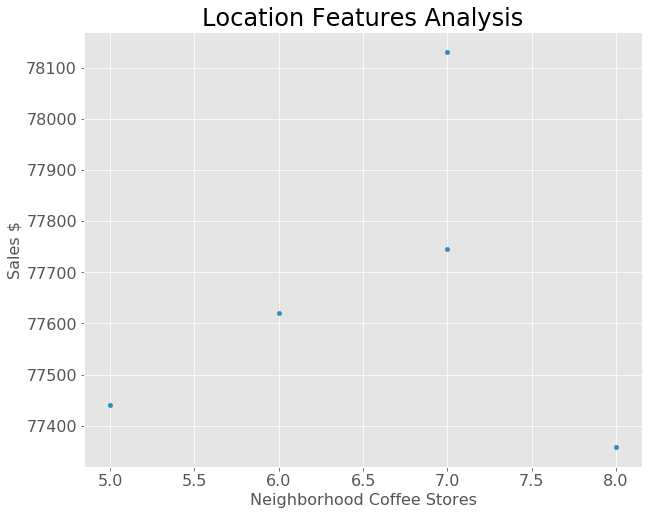

In [66]:
y_hat_locations.plot(figsize=(10,8), kind='scatter', x='Coffee', y='Sales')
plt.title('Location Features Analysis', fontsize=24)
plt.ylabel('Sales $', fontsize=16)
plt.xlabel('Neighborhood Coffee Stores', fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16, rotation='horizontal')
plt.show() # need this line to show the updates made to the figure

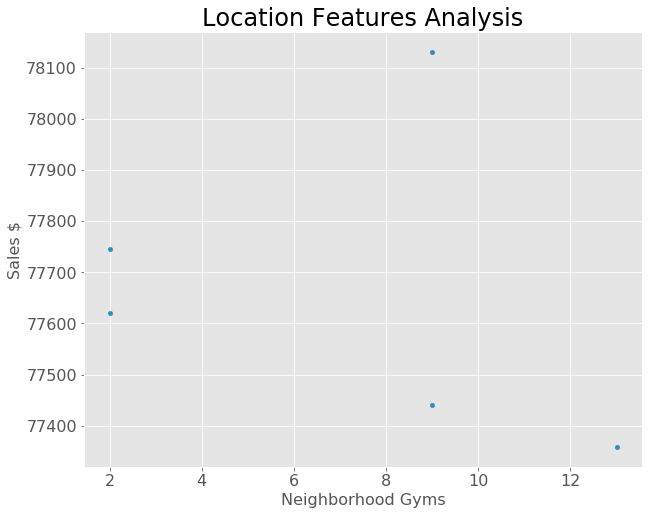

In [67]:
y_hat_locations.plot(figsize=(10,8), kind='scatter', x='Gym', y='Sales')
plt.title('Location Features Analysis', fontsize=24)
plt.ylabel('Sales $', fontsize=16)
plt.xlabel('Neighborhood Gyms', fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16, rotation='horizontal')
plt.show() # need this line to show the updates made to the figure